In [168]:
#import Pkg; Pkg.add("...")
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux, ForwardDiff
using Plots
gr()

Plots.GRBackend()

### Symplectic leapfrog integrator of the form:

## $$ \begin{equation}
    \begin{aligned}
    \textbf{p}_{n+1/2} &= \textbf{p}_{n} - \frac{1}{2} \Delta t V(\textbf{q}_{n})\\
    \textbf{q}_{n+1} &= \textbf{q}_{n} + \Delta t K(\textbf{p}_{n + 1/2})\\
    \textbf{p}_{n+1} &= \textbf{p}_{n+1/2} - \frac{1}{2} \Delta t V(\textbf{q}_{n+1})\\
    \end{aligned}
    \end{equation}
$$

In [176]:
function leapfrog(q0, p0, Δt, N)
    q = [q0]
    p = [p0]
    p̄ = []
    for i ∈ 1:N
        p̄ = push!(p̄, p[end] - 0.5*Δt*V(q[end]))
        q = push!(q, q[end] + Δt*K(p̄[end]))
        p = push!(p, p̄[end] - 0.5*Δt*V(q[end]))
    end
    return [q, p]
end

#For NN functions

function leapfrog_nn(q0, p0, Δt, N)
    q = [q0]
    p = [p0]
    p̄ = []
    for i ∈ 1:N
        p̄ = push!(p̄, p[end] - 0.5*Δt*Vₙₙ([q[end]])[1])
        q = push!(q, q[end] + Δt*Kₙₙ([p̄[end]])[1])
        p = push!(p, p̄[end] - 0.5*Δt*Vₙₙ([q[end]])[1])
    end
    return [q, p]
end

leapfrog_nn (generic function with 2 methods)

## Generate the (noisy) training dataset from:


## $$
\begin{aligned}
  \dot{q} &= \frac{1}{m l^{2}}p \\
  \dot{p} &=  -m l sin(q)
\end{aligned}
$$


In [177]:
#Hamilton equations
m = 1.
l = 1.
V(q) = m*l*sin(q)
K(p) = p/(m*l*l)

#leapfrog integrator parameters
N_tr = 50
N_p = 20
Δt = 0.05

TDataset = []
u0s = []
for i ∈ 1:N_tr
    u0 = Float32[rand((1,-1))*rand()*π, rand((1,-1))*rand()*π]
    u0s = push!(u0s, u0)
    X = leapfrog(u0[1], u0[2], Δt, N_p)
    
    # Add noise to the data
    #Xₙ = X + Float32(1e-3)*randn(eltype(X), size(X))
    #TDataset = push!(TDataset, Xₙ)
    
    TDataset = push!(TDataset, X)

end

TDataset;
u0s;

## Plot the training dataset

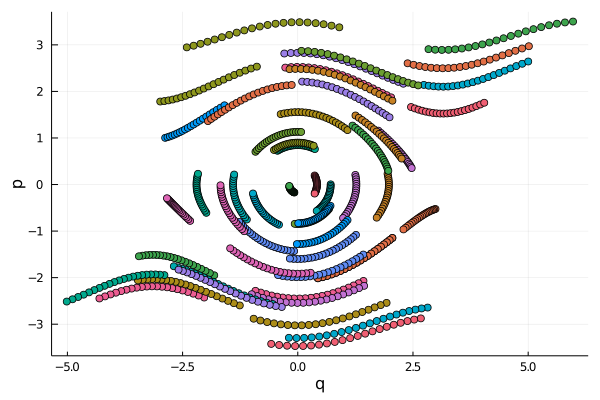

In [178]:
scatter(TDataset[1][1, :], TDataset[1][2, :], label = "", xlabel = "q", ylabel = "p")
for i ∈ 1:(N-1)
    scatter!(TDataset[i][1, :], TDataset[i][2, :], label = "", xlabel = "q", ylabel = "p")
end
scatter!(TDataset[N][1, :], TDataset[N][2, :], label = "", xlabel = "q", ylabel = "p")

### UADE

## $$
\begin{aligned}
  \dot{q} &=  K_{\theta}(p) \\
  \dot{p} &=  -V_{\theta}(q) 
\end{aligned}
$$

In [179]:
Kₙₙ = Chain(Dense(1, 32, tanh), Dense(32, 32, tanh), Dense(32, 1))
Vₙₙ = Chain(Dense(1, 32, tanh), Dense(32, 32, tanh), Dense(32, 1));

## Plot the untrained solution

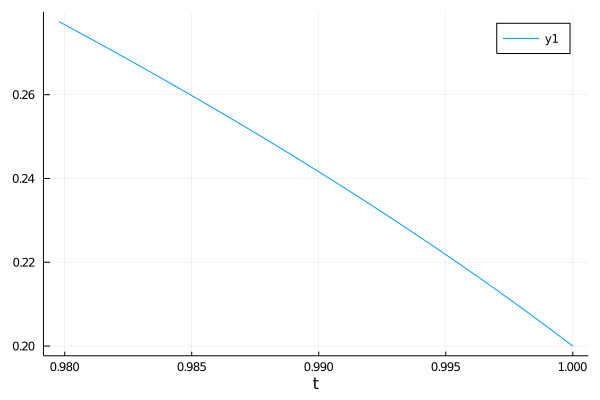

In [180]:
sol = leapfrog_nn(1., 0.2, Δt, N_p)
plot(sol[1,:], sol[2,:], xlabel = "t")

## Training with ADAM

In [174]:
function predict(u0)
    sol = leapfrog_nn(u0[1], u0[2], Δt, N_p)
end

function loss(x, y)
    loss = 0
    for i ∈ 1:N_tr
        pred = predict(u0s[i])
        loss = loss + sum(abs2, Iterators.flatten(TDataset[i] .- pred))
    end
    loss
end

pₖ = Flux.params(Kₙₙ)
pᵥ = Flux.params(Vₙₙ);

In [181]:
Flux.train!(loss, pᵥ, [(0,0)], ADAM(0.01))
#loss(0,0)

ErrorException: Mutating arrays is not supported